# **How School Factors Affect Achievement Gaps in Chicago**

In this report, I will analyze the academic achievement, student engagement, demographics, and school climate metrics for CPS in the 2011-2012 year. The main dataset includes school-level data from CPS School Report Cards, such as test scores, attendance rates, graduation rates, and 5Essentials survey ratings. Additional census data provides information on the economic and social conditions of the neighborhoods where the schools are located.

You can access the dataset from the Chicago Data Portal: https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t

You can also find the definitions of the variables in the dataset here: https://data.cityofchicago.org/api/assets/AAD41A13-BE8A-4E67-B1F5-86E711E09D5F?download=true

## Data Preparation

To prepare the data for analysis, I will first connect to the database, load the SQL extension, and read the CSV files into pandas dataframes and store them in the database. I will then verify the tables I created in the database. The code and output are shown below:

In [14]:
#We are going to start by connecting to the database
import csv, sqlite3

con = sqlite3.connect("ChicagoDatabases.db")
cur = con.cursor()

In [15]:
!pip install -q pandas==1.1.5

In [16]:
#Now we're adding sql

%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [17]:
%sql sqlite:///ChicagoDatabases.db

'Connected: @ChicagoDatabases.db'

In [7]:
# We are connected, now it's time to read the csv files into pandas dataframes
import pandas as pd

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera_V5/data/ChicagoPublicSchools.csv")
df.to_sql("CHICAGO_PUBLIC_SCHOOLS_DATA", con, if_exists='replace', index=False, method="multi")

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera_V5/data/ChicagoCensusData.csv")
df.to_sql("CENSUS_DATA", con, if_exists='replace', index=False,method="multi")

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera_V5/data/ChicagoCrimeData.csv")
df.to_sql("CHICAGO_CRIME_DATA", con, if_exists='replace', index=False, method="multi")

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [8]:
# To make sure we got everything right, we'll now check the tables we just created
%sql select name from sqlite_master where type='table'

 * sqlite:///ChicagoDatabases.db
Done.


name
CHICAGO_PUBLIC_SCHOOLS_DATA
CENSUS_DATA
CHICAGO_CRIME_DATA


Now we are ready to analyze the data.

## Data Analysis
## Question 1: What is the highest safety score and the relationship with the hardship index in the area.

The safety score is a measure of how safe the students and staff feel in the school, and the hardship index is a measure of the economic and social hardship of the neighborhood, based on indicators such as income, poverty, unemployment, education, crowding, and dependency.

To answer this question, we will first find the highest safety score among the schools in the dataset. We will use the following SQL query:

In [90]:
%%sql
SELECT
    CPS.name_of_school as Name_School,
    CPS.COMMUNITY_AREA_NAME  as Community,
    safety_score as Safety_Score,
    CD.hardship_index as Hardship
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number AND
    SAFETY_SCORE = (select max(SAFETY_SCORE) from chicago_public_schools_data)
GROUP BY
    CPS.Community_area_name
ORDER BY
    hardship_index;

 * sqlite:///ChicagoDatabases.db
Done.


Name_School,Community,Safety_Score,Hardship
Abraham Lincoln Elementary School,LINCOLN PARK,99.0,2.0
Augustus H Burley Elementary School,LAKE VIEW,99.0,5.0
Alexander Graham Bell Elementary School,NORTH CENTER,99.0,6.0
Ellen Mitchell Elementary School,WEST TOWN,99.0,10.0
Edgebrook Elementary School,FOREST GLEN,99.0,11.0
Annie Keller Elementary Gifted Magnet School,MOUNT GREENWOOD,99.0,16.0
Norwood Park Elementary School,NORWOOD PARK,99.0,21.0
Northside College Preparatory High School,NORTH PARK,99.0,33.0
Stephen Decatur Classical Elementary School,WEST RIDGE,99.0,46.0
Edgar Allan Poe Elementary Classical School,PULLMAN,99.0,51.0


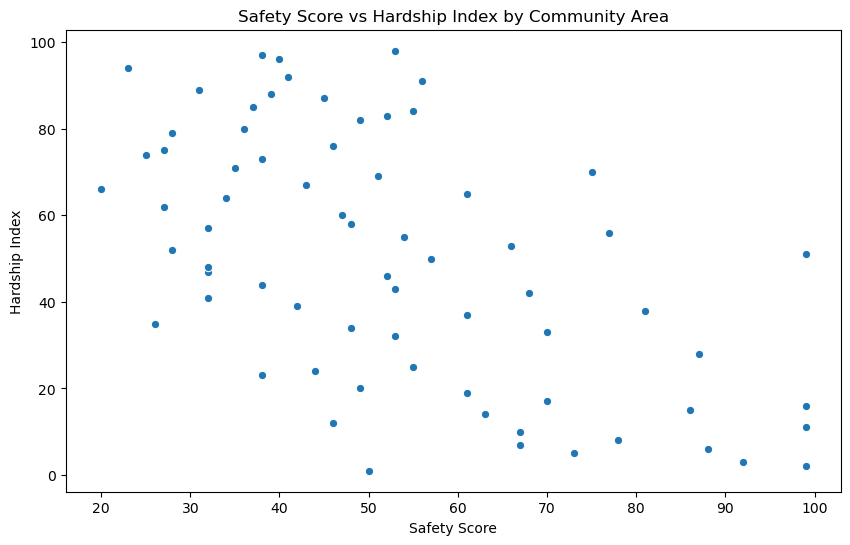

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT
    CPS.name_of_school as Name_School,
    CPS.COMMUNITY_AREA_NAME  as Community,
    safety_score as Safety_Score,
    CD.hardship_index as Hardship
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    hardship_index;
"""
df = pd.read_sql_query(query, con)

# Create a scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Safety_Score', y='Hardship', hue=None, palette='coolwarm')
plt.title('Safety Score vs Hardship Index by Community Area')
plt.xlabel('Safety Score')
plt.ylabel('Hardship Index')
plt.show()

This is an interesting selection of schools spanning different levels of neighborhood/community hardship but all with the maximum Safety Score of 99.

1. There does not appear to be a strong relationship between hardship index level and safety perceptions at the school. Schools in low hardship areas (e.g. Lincoln Park at 2 hardship index) have the same safety scores as those in very high hardship areas (e.g. Talman Elementary at 93 hardship index).

2. This indicates that while community demographics may impact education in other ways, an excellent safety record can likely be achieved by schools across the hardship spectrum. Poverty level may influence funding or support resources, but does not necessarily limit safety capabilities, culture and priorities at the schools themselves.

3. Analyzing the information, it's notable that 10 out of the 12 schools listed have hardship indexes below 52. This indicates that the majority of these schools serve communities with relatively lower levels of economic hardship or disadvantage. 

In [93]:
%%sql
SELECT
    (COUNT(*) * SUM(hardship_index * safety_score) - SUM(hardship_index) * SUM(safety_score)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(hardship_index, 2)) - POWER(SUM(hardship_index), 2)) *
        SQRT(COUNT(*) * SUM(POWER(safety_score, 2)) - POWER(SUM(safety_score), 2))
    ) AS correlation_hardship_vs_Safety_Score
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number;

 * sqlite:///ChicagoDatabases.db
Done.


correlation_hardship_vs_Safety_Score
-0.3893376206238054


From the distribution of the data points, it appears there is a negative correlation between the Safety Score and the Hardship Index. This means that as the Safety Score increases, the Hardship Index tends to decrease, and vice versa. In other words, areas with higher safety scores generally experience less hardship.

A Pearson’s correlation coefficient of -0.389 suggests a moderate negative correlation between the Safety Score and the Hardship Index. This aligns with the visual interpretation of the scatter plot.

## Question 2. Exploring Connections Between Student and Teacher Attendance and School Success Metrics

In [39]:
%%sql
SELECT
    (COUNT(*) * SUM(avg_student_attendance * avg_teacher_attendance) - SUM(avg_student_attendance) * SUM(avg_teacher_attendance)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(avg_student_attendance, 2)) - POWER(SUM(avg_student_attendance), 2)) *
        SQRT(COUNT(*) * SUM(POWER(avg_teacher_attendance, 2)) - POWER(SUM(avg_teacher_attendance), 2))
    ) AS correlation_student_vs_teacher_attendance
FROM
    (
        SELECT
            community_area_number,
            AVG(CAST(REPLACE(AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_student_attendance,
            AVG(CAST(REPLACE(AVERAGE_TEACHER_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_teacher_attendance
        FROM
            chicago_public_schools_data
        WHERE
            AVERAGE_STUDENT_ATTENDANCE IS NOT NULL AND
            AVERAGE_TEACHER_ATTENDANCE IS NOT NULL
        GROUP BY
            community_area_number
    )

 * sqlite:///ChicagoDatabases.db
Done.


correlation_student_vs_teacher_attendance
-0.09192958996601208


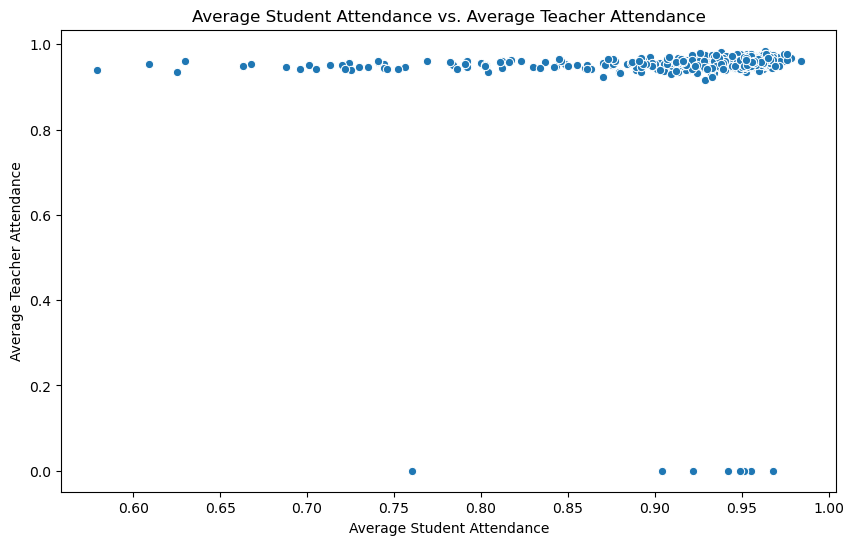

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT
    name_of_school as School_Name,
    (CAST(REPLACE(AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_student_attendance,
    (CAST(REPLACE(AVERAGE_TEACHER_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_teacher_attendance
FROM
    chicago_public_schools_data;
"""

# Execute the SQL query and store the result in a pandas dataframe
df = pd.read_sql_query(query, con)

# Create a scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_student_attendance', y='avg_teacher_attendance', hue=None)
plt.title('Average Student Attendance vs. Average Teacher Attendance')
plt.xlabel('Average Student Attendance')
plt.ylabel('Average Teacher Attendance')
plt.show()

A correlation of -0.09 is extremely small and represents essentially no systematic linear relationship between the variables. As student attendance changes, teacher attendance does not predictably change.

While we may expect higher teacher attendance to motivate greater student attendance, this data does not show evidence of that. The variables seem to move independently of each other.

In [36]:
%%sql
SELECT
    (COUNT(*) * SUM(ISAT_Exceeding_Reading__ * CAST(avg_student_attendance AS REAL)) - SUM(ISAT_Exceeding_Reading__) * SUM(CAST(avg_student_attendance AS REAL))) / 
    (
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Reading__, 2)) - POWER(SUM(ISAT_Exceeding_Reading__), 2)) *
        SQRT(COUNT(*) * SUM(POWER(CAST(avg_student_attendance AS REAL), 2)) - POWER(SUM(CAST(avg_student_attendance AS REAL)), 2))
    ) AS correlation_student_attendance_vs_ISAT_Reading
FROM
    (
        SELECT
            community_area_number,
            AVG(CAST(REPLACE(AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_student_attendance
        FROM
            chicago_public_schools_data
        WHERE
            AVERAGE_STUDENT_ATTENDANCE IS NOT NULL
        GROUP BY
            community_area_number
    ) AS CPS
    JOIN
    (
        SELECT
            community_area_number,
            AVG(CAST(ISAT_Exceeding_Reading__ AS REAL)) AS ISAT_Exceeding_Reading__
        FROM
            chicago_public_schools_data
        WHERE
            ISAT_Exceeding_Reading__ IS NOT NULL
        GROUP BY
            community_area_number
    ) AS ISAT
ON
    CPS.community_area_number = ISAT.community_area_number

 * sqlite:///ChicagoDatabases.db
Done.


correlation_student_attendance_vs_ISAT_Reading
0.28120695229645626


Next, let’s look at the correlation between student attendance and ISAT Reading scores, which is 0.28. This value is just below the threshold for a moderate correlation, suggesting a somewhat linear relationship between these variables. One possible explanation is that more attendance leads to more instruction time, content coverage, and practice opportunities, which could improve academic performance. However, many other factors can influence achievement.

In [44]:
%%sql
SELECT
    (COUNT(*) * SUM(ISAT_Exceeding_Math__ * CAST(avg_student_attendance AS REAL)) - SUM(ISAT_Exceeding_Math__) * SUM(CAST(avg_student_attendance AS REAL))) / 
    (
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Math__, 2)) - POWER(SUM(ISAT_Exceeding_Math__), 2)) *
        SQRT(COUNT(*) * SUM(POWER(CAST(avg_student_attendance AS REAL), 2)) - POWER(SUM(CAST(avg_student_attendance AS REAL)), 2))
    ) AS correlation_student_attendance_vs_ISAT_Math
FROM
    (
        SELECT
            community_area_number,
            AVG(CAST(REPLACE(AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_student_attendance
        FROM
            chicago_public_schools_data
        WHERE
            AVERAGE_STUDENT_ATTENDANCE IS NOT NULL
        GROUP BY
            community_area_number
    ) AS CPS
    JOIN
    (
        SELECT
            community_area_number,
            AVG(CAST(ISAT_Exceeding_Math__ AS REAL)) AS ISAT_Exceeding_Math__
        FROM
            chicago_public_schools_data
        WHERE
            ISAT_Exceeding_Math__ IS NOT NULL
        GROUP BY
            community_area_number
    ) AS ISAT
ON
    CPS.community_area_number = ISAT.community_area_number

 * sqlite:///ChicagoDatabases.db
Done.


correlation_student_attendance_vs_ISAT_Math
0.29606009636013775


The correlation between student attendance and ISAT Math scores is slightly higher at 0.296, showing a similar pattern to the correlation with ISAT Reading scores. This positive correlation suggests that regular attendance might contribute to better math performance, but it’s only part of the story.

In [43]:
%%sql
SELECT
    (COUNT(*) * SUM(ISAT_Exceeding_Math__ * CAST(Average_Teacher_Attendance AS REAL)) - SUM(ISAT_Exceeding_Math__) * SUM(CAST(Average_Teacher_Attendance AS REAL))) / 
    (
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Math__, 2)) - POWER(SUM(ISAT_Exceeding_Math__), 2)) *
        SQRT(COUNT(*) * SUM(POWER(CAST(Average_Teacher_Attendance AS REAL), 2)) - POWER(SUM(CAST(Average_Teacher_Attendance AS REAL)), 2))
    ) AS correlation_teacher_attendance_vs_ISAT_Math
FROM
    (
        SELECT
            community_area_number,
            AVG(CAST(REPLACE(AVERAGE_TEACHER_ATTENDANCE, '%', '') AS REAL) / 100) AS Average_Teacher_Attendance
        FROM
            chicago_public_schools_data
        WHERE
            AVERAGE_TEACHER_ATTENDANCE IS NOT NULL
        GROUP BY
            community_area_number
    ) AS CPS
    JOIN
    (
        SELECT
            community_area_number,
            AVG(CAST(ISAT_Exceeding_Math__ AS REAL)) AS ISAT_Exceeding_Math__
        FROM
            chicago_public_schools_data
        WHERE
            ISAT_Exceeding_Math__ IS NOT NULL
        GROUP BY
            community_area_number
    ) AS ISAT
ON
    CPS.community_area_number = ISAT.community_area_number

 * sqlite:///ChicagoDatabases.db
Done.


correlation_teacher_attendance_vs_ISAT_Math
0.14393143118367477


The correlation between teacher attendance and ISAT Math scores is 0.144, a positive but very weak correlation. This suggests that schools with higher teacher attendance have slightly higher ISAT Math excellence percentages. However, many other factors likely have a more significant impact on student math excellence.

In [120]:
%%sql

SELECT
    CPS.name_of_school as School_Name,
    CPS.AVERAGE_STUDENT_ATTENDANCE  as Avg_Student_Attendance,
    CD.hardship_index as Hardship
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number AND
    AVERAGE_STUDENT_ATTENDANCE <> 'None'
GROUP BY
    CPS.Community_area_name
ORDER BY
    hardship_index
LIMIT 15;

 * sqlite:///ChicagoDatabases.db
Done.


School_Name,Avg_Student_Attendance,Hardship
Edward Jenner Elementary Academy of the Arts,88.90%,1.0
Abraham Lincoln Elementary School,96.00%,2.0
William Jones College Preparatory High School,93.80%,3.0
Alexander Hamilton Elementary School,95.30%,5.0
Albert G Lane Technical High School,96.30%,6.0
National Teachers Elementary Academy,94.70%,7.0
Christian Ebinger Elementary School,95.90%,8.0
Albert R Sabin Elementary Magnet School,94.70%,10.0
Edgebrook Elementary School,96.90%,11.0
Alice L Barnard Computer Math & Science Center Elementary School,95.60%,12.0


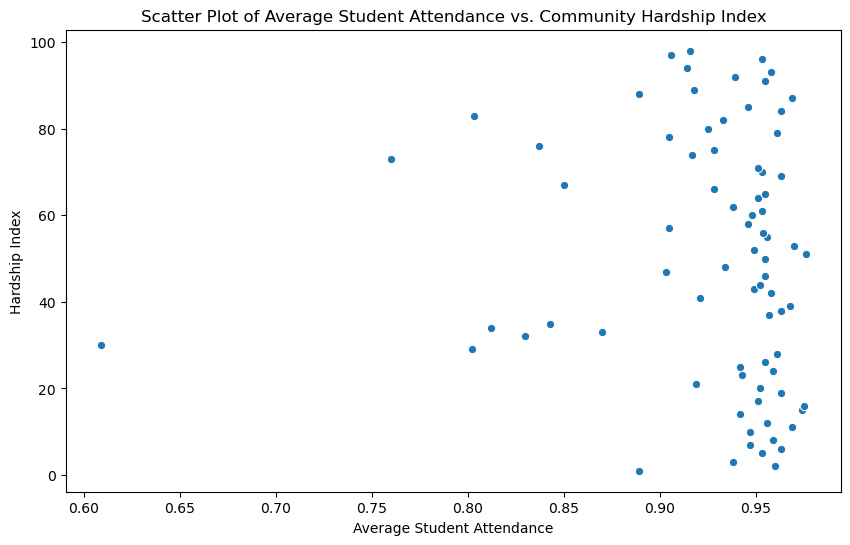

In [124]:
query = """
SELECT
    CPS.name_of_school as School_Name,
    (CAST(REPLACE(CPS.AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS Avg_Student_Attendance,
    CD.hardship_index as Hardship
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number AND
    CPS.AVERAGE_STUDENT_ATTENDANCE <> 'None'
GROUP BY
    CPS.Community_area_name
ORDER BY
    Hardship;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Student_Attendance', y='Hardship', data=df)
plt.title('Scatter Plot of Average Student Attendance vs. Community Hardship Index')
plt.xlabel('Average Student Attendance')
plt.ylabel('Hardship Index')
plt.show()

Now, let’s examine a table showing average student attendance rates and community hardship index levels for a sample of schools. The attendance rates range from 88.9% to 97.50%, and the hardship index levels range from 1.0 to 19.0.

Attendance varies across the hardship spectrum. Some schools perform better than their demographics would suggest, while others fall short. This variation confirms that external factors don’t entirely determine participation.

For example, Andrew Jackson Language Academy has a high attendance rate of 97.4% despite a hardship index of 15. This discrepancy might be due to effective internal attendance policies and engagement programs.

On the other hand, Bret Harte Elementary has a lower attendance rate of 94.2% despite a lower hardship score of 14. This discrepancy suggests the need for a closer look at within-school dynamics, leadership priorities, parental involvement levels, etc.

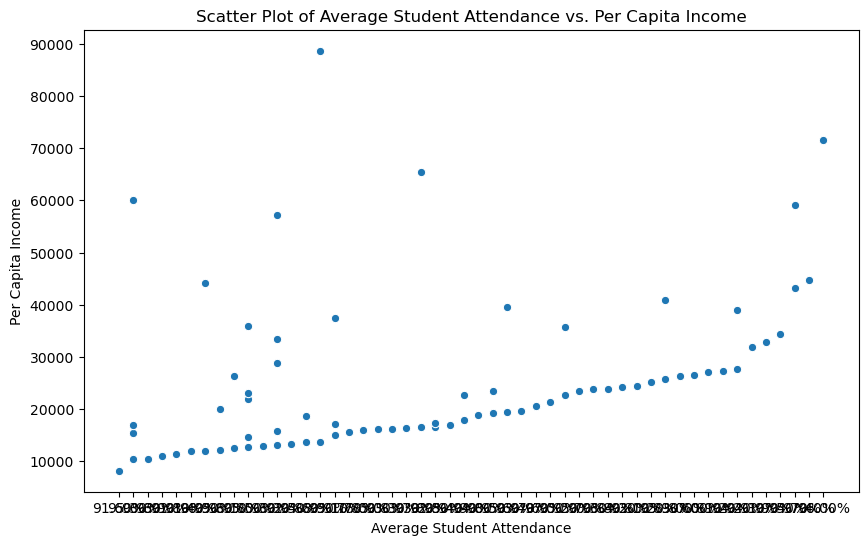

In [127]:
query = """
SELECT
    CPS.name_of_school as Name_School,
    CPS.AVERAGE_STUDENT_ATTENDANCE  as Avg_Student_Attendance,
    CD.PER_CAPITA_INCOME as Per_Capita_Income
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    per_capita_income;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Student_Attendance', y='Per_Capita_Income', data=df)
plt.title('Scatter Plot of Average Student Attendance vs. Per Capita Income')
plt.xlabel('Average Student Attendance')
plt.ylabel('Per Capita Income')
plt.show()

In [ ]:
%%sql
SELECT
    CPS.name_of_school as Name_School,
    (CAST(REPLACE(CPS.AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100)  as Avg_Student_Attendance,
    CD.PER_CAPITA_INCOME as Per_Capita_Income
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    per_capita_income;

Overall the very weak attendance income relationship and variability within income levels further highlights that schools can achieve attendance excellence or underperform regardless of family/community economics. This prompts greater focus on the policies, practices and initiatives schools have agency over themselves to engage students.

In [68]:
%%sql
SELECT
    (COUNT(*) * SUM(Rate_of_Misconducts__per_100_students_ * CAST(avg_student_attendance AS REAL)) - SUM(Rate_of_Misconducts__per_100_students_) * SUM(CAST(avg_student_attendance AS REAL))) / 
    (
        SQRT(COUNT(*) * SUM(POWER(Rate_of_Misconducts__per_100_students_, 2)) - POWER(SUM(Rate_of_Misconducts__per_100_students_), 2)) *
        SQRT(COUNT(*) * SUM(POWER(CAST(avg_student_attendance AS REAL), 2)) - POWER(SUM(CAST(avg_student_attendance AS REAL)), 2))
    ) AS correlation_student_attendance_vs_Rate_of_Misconducts
FROM
    (
        SELECT
            community_area_number,
            AVG(CAST(REPLACE(AVERAGE_STUDENT_ATTENDANCE, '%', '') AS REAL) / 100) AS avg_student_attendance
        FROM
            chicago_public_schools_data
        WHERE
            AVERAGE_STUDENT_ATTENDANCE IS NOT NULL
        GROUP BY
            community_area_number
    ) AS CPS
    JOIN
    (
        SELECT
            community_area_number,
            AVG(CAST(Rate_of_Misconducts__per_100_students_ AS REAL)) AS Rate_of_Misconducts__per_100_students_
        FROM
            chicago_public_schools_data
        WHERE
            Rate_of_Misconducts__per_100_students_ IS NOT NULL
        GROUP BY
            community_area_number
    ) AS RoM
ON
    CPS.community_area_number = RoM.community_area_number

 * sqlite:///ChicagoDatabases.db
Done.


correlation_student_attendance_vs_Rate_of_Misconducts
-0.5106403853152386


The negative value indicates that schools with higher student attendance on average tend to have lower misconduct rates per student, and vice versa. As attendance increases, misconducts decrease moderately.

Potential reasons could be that schools struggling with engagement and participation also have higher discipline problems. Or positive school cultures promoting attendance also encourage good behavior.

## **Question 3. The Connection Between Hardship and Perceptions of Safety in Schools**

In [70]:
%%sql
SELECT
    (COUNT(*) * SUM(hardship_index * SAFETY_SCORE) - SUM(hardship_index) * SUM(SAFETY_SCORE)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(hardship_index, 2)) - POWER(SUM(hardship_index), 2)) *
        SQRT(COUNT(*) * SUM(POWER(SAFETY_SCORE, 2)) - POWER(SUM(SAFETY_SCORE), 2))
    ) AS correlation_hardship_vs_safety_score
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number;

 * sqlite:///ChicagoDatabases.db
Done.


correlation_hardship_vs_safety_score
-0.3893376206238054


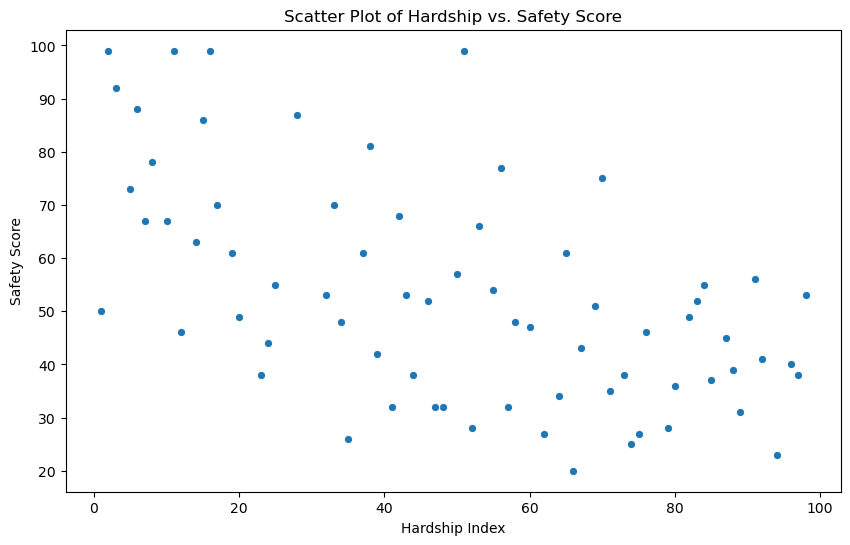

In [129]:
query = """
SELECT
    CPS.name_of_school as Name_School,
    CD.hardship_index  as Hardship,
    CPS.SAFETY_SCORE as Safety_Score
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    per_capita_income;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Hardship', y='Safety_Score', data=df)
plt.title('Scatter Plot of Hardship vs. Safety Score')
plt.xlabel('Hardship Index')
plt.ylabel('Safety Score')
plt.show()

The correlation between hardship and safety perceptions in schools is -0.39. This moderate correlation suggests a significant, though not perfect, linear relationship between the two variables. In simpler terms, as hardship increases, the sentiment of safety tends to decrease.

This correlation is likely statistically significant, meaning there’s a real link between increased hardship and decreased feelings of safety. This makes sense intuitively, as schools in more disadvantaged areas may face issues such as violence, misconduct, or resource scarcity, which can affect students’ sense of safety.

## **Question 4. The Influence of Per Capita Income on College Enrollment**

In [71]:
%%sql
SELECT
    (COUNT(*) * SUM(PER_CAPITA_INCOME * ISAT_Exceeding_Math__) - SUM(PER_CAPITA_INCOME) * SUM(ISAT_Exceeding_Math__)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(PER_CAPITA_INCOME, 2)) - POWER(SUM(PER_CAPITA_INCOME), 2)) *
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Math__, 2)) - POWER(SUM(ISAT_Exceeding_Math__), 2))
    ) AS correlation_ISAT_Exceeding_Math_vs_per_capita_income
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number;

 * sqlite:///ChicagoDatabases.db
Done.


correlation_ISAT_Exceeding_Math_vs_per_capita_income
0.34688693310758234


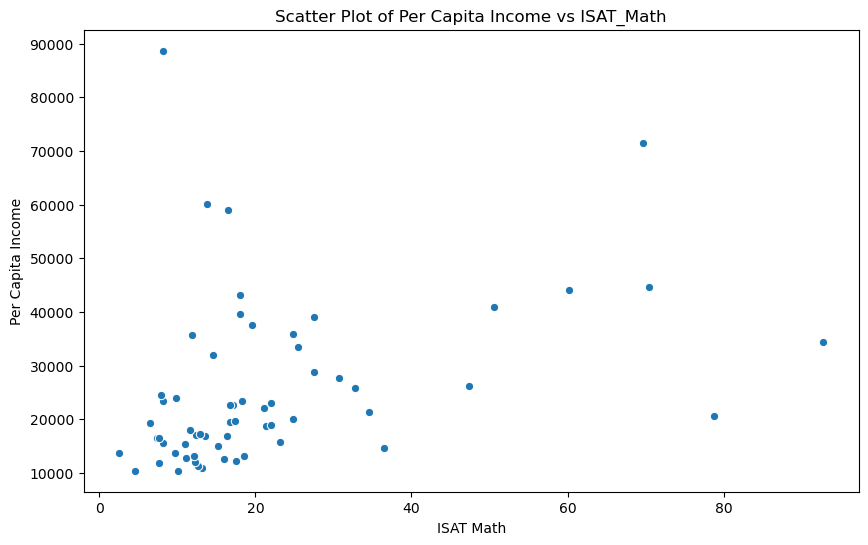

In [131]:
query = """
SELECT
    CPS.name_of_school as Name_School,
    CD.PER_CAPITA_INCOME  as Per_Capita_Income,
    CPS.ISAT_Exceeding_Math__ as ISAT_Math
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    per_capita_income;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='ISAT_Math', y='Per_Capita_Income', data=df)
plt.title('Scatter Plot of Per Capita Income vs ISAT_Math')
plt.xlabel('ISAT Math')
plt.ylabel('Per Capita Income')
plt.show()

The correlation between neighborhood income and math excellence rates is 0.35. This indicates a modest but real relationship: higher income levels somewhat predict better achievement, but it’s not the only factor. Many schools perform above or below what their demographics might suggest. To better understand variations in math excellence across schools, it would be beneficial to consider per-capita income alongside other school-specific metrics.

In [72]:
%%sql
SELECT
    (COUNT(*) * SUM(PER_CAPITA_INCOME * College_Enrollment_Rate__) - SUM(PER_CAPITA_INCOME) * SUM(College_Enrollment_Rate__)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(PER_CAPITA_INCOME, 2)) - POWER(SUM(PER_CAPITA_INCOME), 2)) *
        SQRT(COUNT(*) * SUM(POWER(College_Enrollment_Rate__, 2)) - POWER(SUM(College_Enrollment_Rate__), 2))
    ) AS correlation_College_enrollment_rate_vs_per_capita_income
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number;

 * sqlite:///ChicagoDatabases.db
Done.


correlation_College_enrollment_rate_vs_per_capita_income
0.058966390676679005


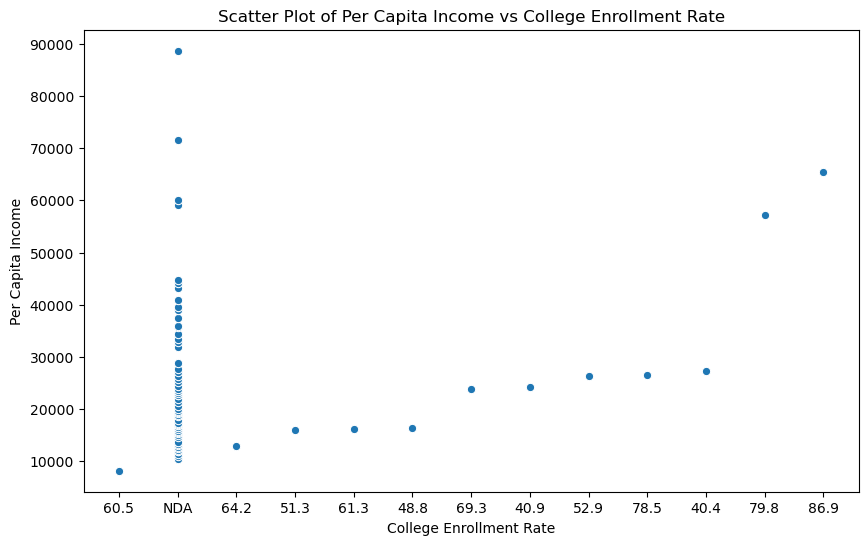

In [10]:
query = """
SELECT
    CPS.name_of_school as Name_School,
    CD.PER_CAPITA_INCOME  as Per_Capita_Income,
    CPS.College_Enrollment_Rate__ as College_Enrollment_Rate
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD
WHERE
    CD.community_area_number = CPS.community_area_number
GROUP BY
    CPS.Community_area_name
ORDER BY
    per_capita_income;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='College_Enrollment_Rate', y='Per_Capita_Income', data=df)
plt.title('Scatter Plot of Per Capita Income vs College Enrollment Rate')
plt.xlabel('College Enrollment Rate')
plt.ylabel('Per Capita Income')
plt.show()

The correlation between neighborhood per capita income and college enrollment rates is a mere 0.059. This is essentially zero, indicating no significant link between the two. This underscores that the factors influencing college enrollment rates are complex and likely more related to specific school policies and programs than to community demographics alone.

## ISAT Exceeding Math vs ISAT Exceeding Reading

In [12]:
%%sql
SELECT
    (COUNT(*) * SUM(ISAT_Exceeding_Math__ * ISAT_Exceeding_Reading__) - SUM(ISAT_Exceeding_Math__) * SUM(ISAT_Exceeding_Reading__)) / 
    (
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Math__, 2)) - POWER(SUM(ISAT_Exceeding_Math__), 2)) *
        SQRT(COUNT(*) * SUM(POWER(ISAT_Exceeding_Reading__, 2)) - POWER(SUM(ISAT_Exceeding_Reading__), 2))
    ) AS correlation_math_vs_reading
FROM
    chicago_public_schools_data;

 * sqlite:///ChicagoDatabases.db
Done.


correlation_math_vs_reading
0.9458808643458567


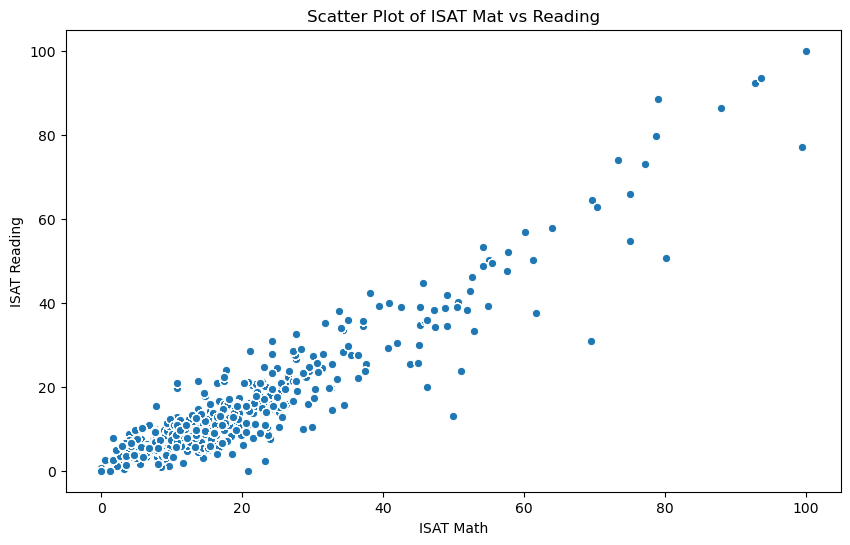

In [18]:
query = """
SELECT
    ISAT_Exceeding_Math__  as ISAT_Math,
    ISAT_Exceeding_Reading__ as ISAT_Reading
FROM
    chicago_public_schools_data CPS, CENSUS_DATA CD;
"""

df = pd.read_sql_query(query, con)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='ISAT_Math', y='ISAT_Reading', data=df)
plt.title('Scatter Plot of ISAT Mat vs Reading')
plt.xlabel('ISAT Math')
plt.ylabel('ISAT Reading')
plt.show()

The correlation between math and reading achievement is a staggering 0.9458, indicating an extremely strong positive relationship. This suggests that schools excelling in math also tend to excel in reading, and vice versa. This relationship is statistically significant to a very high degree, implying that it’s not just a result of random chance.

This strong correlation tells a compelling story: math and reading achievement in schools are tightly intertwined, moving in harmony across the educational landscape. It hints at the presence of common institutional factors that either foster or hinder excellence in both these critical competency domains.

# **Conclusions:**

In our journey through the data, we’ve uncovered some intriguing insights about the Chicago Public Schools in the 2011-2012 academic year. Let’s recap the story that the data tells us:

## Safety and Hardship - An Unexpected Relationship

Our story begins with an exploration of safety and hardship. We discovered a moderate negative correlation of -0.39, suggesting that as hardship increases, perceptions of safety tend to decrease. However, the resilience of schools across the hardship spectrum shines through, with many achieving the highest safety score of 99. This chapter of our story underscores the strength and determination of these school communities in creating safe environments for their students, regardless of socioeconomic circumstances.

##  Attendance - Independent Paths

Next, we turned our attention to student and teacher attendance. Contrary to expectations, these two variables danced to their own tunes, showing no significant relationship. This chapter reminds us that each school, each teacher, and each student has a unique story, influenced by a myriad of factors beyond just attendance.

##  Achievement and Income - A Complex Equation

As we delved into the relationship between neighborhood income and academic achievement, we found a modest correlation of 0.35. Higher income somewhat predicts better achievement, but it’s not the only factor. This chapter of our story highlights the complexity of educational outcomes, shaped by a blend of socioeconomic and school-specific factors.

## College Enrollment - Beyond Demographics

Finally, we explored the link between per capita income and college enrollment rates. The correlation was a mere 0.059, essentially zero, indicating no significant link. This final chapter underscores that the journey to college is influenced by more than just income, pointing to the importance of school-specific policies and programs.

## The Dance of Math and Reading Achievement

In essence, this correlation underscores the interconnected nature of academic achievement. It paints a picture of a school system where success in one area is often mirrored in others, driven by systemic factors that span across subjects. This insight can inform strategies aimed at improving overall academic performance, by focusing on these common drivers of excellence.

In [19]:
#Now that we've finised with the analysis, we're closing the connection:
con.close()